In [10]:
import sys
sys.path.append("./src")
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import compute_misfit, get_tstamp
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

matplotlib.rcParams.update({'font.size': 16})

psd_data = '/fd1/QibinShi_data/England_farm/psd_all.hdf5'  ## big file on server
harper_met = 'data/NewportSalop_merged.csv'
reg_met = 'data/met_newport.csv'
spatial_data = 'data/interp_dv_tillage_tire.csv'


freqmin=25
freqmax=50
samp_freq = 500
dchan = 3.19

# Data 

## Data 1 -- dV/V

In [23]:
with h5py.File('data/final_peaks_interp_smooth.h5', 'r') as f:
    amp = f['smooth1d_dvv'][:]

minamp= np.nanmin(amp[:,800:1520], axis=1)
maxamp= np.nanmax(amp[:,800:1520], axis=1)

dvv_range = maxamp - minamp

## Data 2 -- PSD for raining time

In [18]:
### PSD of high frequency DAS
with h5py.File(psd_data, 'r') as f:
    freq = f['frequency'][:]
    file_list = f['daslist'][:]
    PSD_all_time = f['psd_all_time'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0) - 0.0007

xax=np.arange(7, ave_psd.shape[-1], 360)
tax=acqu_time[7:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]

## Data 3 -- Tillage and Compaction from table

In [20]:
#### Use three-plot width as the spare the width
tillage = np.array([0,0,0,   10, 0, 25, 0, 10, 25, 25, 0, 10,    0,0,0,    25, 25, 0, 0, 0, 10, 10, 10, 25,    0,0,0,   10, 10, 0, 0, 10, 25, 0, 25, 25])
tire = np.array([0,0,0,  7, 7, 12, 7, 12, 7, 7, 12, 7,    0,0,0,     12, 7, 7, 12, 7, 12, 7, 7, 7,    0,0,0,    12, 7, 7, 12, 7, 7, 7, 7, 12])
randomness = np.array([-1,-1,-1, 1, 2, 2, 0, 2, 0, 2, 2, 0, -1,-1,-1, 2, 0, 2, 2, 0, 2, 2, 0, 2, -1,-1,-1, 2, 0, 2, 2, 2, 0, 0, 2, 2])

#### Interpolate tillage and tire pressure
f = interp1d(np.arange(36)*4-3, tillage, bounds_error=False, fill_value=1)
intep_tillage = f(np.arange(51-6)*dchan)

f = interp1d(np.arange(36)*4-3, tire, bounds_error=False, fill_value=1)
intep_tire = f(np.arange(51-6)*dchan)

smooth_tillage = gaussian_filter1d(intep_tillage, sigma=2, mode='reflect')
smooth_tire = gaussian_filter1d(intep_tire, sigma=2, mode='reflect')

# Compare

Text(0, 0.5, 'tillage * tire')

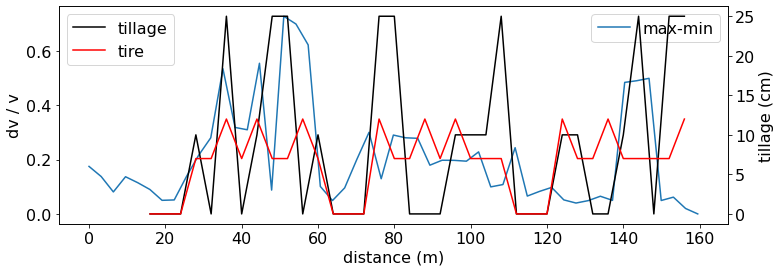

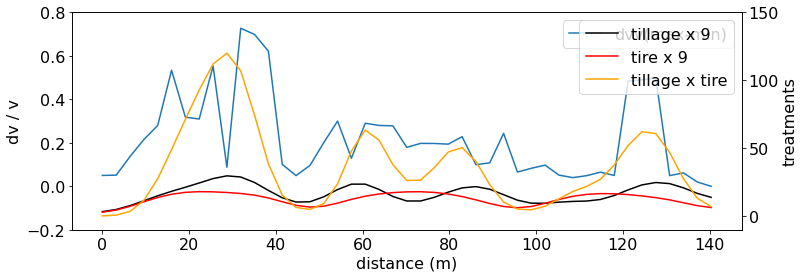

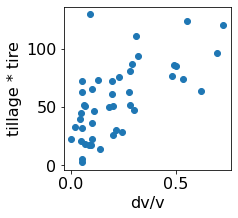

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(51)*dchan, maxamp-minamp, label='max-min')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("dv / v", fontsize = 16)
plt.legend()

axcopy = plt.twinx()
axcopy.set_ylabel("tillage (cm)", fontsize = 16)
axcopy.plot(np.arange(36)*4+16, tillage, color='k', label='tillage')
axcopy.plot(np.arange(36)*4+16, tire, color='r', label='tire')
axcopy.legend()

### Plot
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(dvv_range[6:]))*dchan, dvv_range[6:], label='dvv(max-min)')
plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("dv / v", fontsize = 16)
plt.legend()
plt.ylim(-0.2, 0.8)

axcopy = plt.twinx()
axcopy.plot(np.arange(len(smooth_tillage))*dchan, smooth_tillage*2, color='k', label='tillage x 9')
axcopy.plot(np.arange(len(smooth_tire))*dchan, smooth_tire*2, color='r', label='tire x 9')
axcopy.plot(np.arange(len(smooth_tire))*dchan, smooth_tillage**1.6*smooth_tire**1.6/20, color='orange', label='tillage x tire')

axcopy.set_ylabel("treatments", fontsize = 16)
axcopy.legend()
axcopy.set_ylim(-10, 150)


#### covariance
plt.figure(figsize=(3, 3))
plt.plot(dvv_range[6:],smooth_tillage*smooth_tire,'o')
plt.xlabel("dv/v", fontsize = 16)
plt.ylabel("tillage * tire", fontsize = 16)

## Save smoothed damage parameters

In [26]:
interp_paras = pd.DataFrame(data={'dvv_varibility': dvv_range[6:],
                                'tillage_depth': smooth_tillage, 
                                'tire_pressure': smooth_tire})

interp_paras.to_csv('data/interp_dv_tillage_tire.csv')

# Grid Search

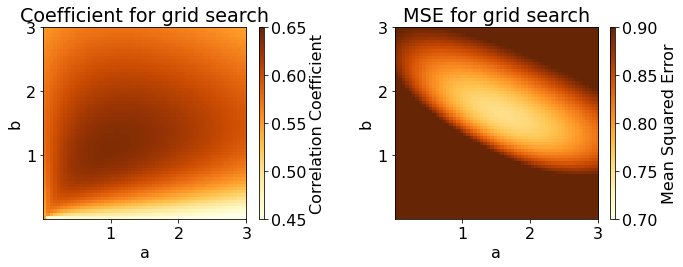

Largest correlation coefficient: 0.6365267891606724
Best a: 1.101
Best b: 0.9510000000000001
Smallest mean squared error: 0.7533396223914718
Best a: 1.601
Best b: 1.601


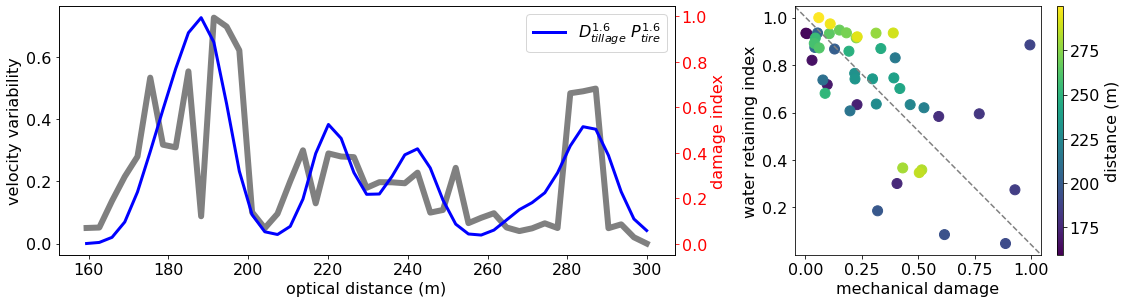

cross-corr: 0.6251018225691619
mse: 0.7533396223914718


In [27]:
### Read the data from the interpolated file
tillage_interpolated = pd.read_csv(spatial_data)['tillage_depth'].to_numpy()
tire_interpolated = pd.read_csv(spatial_data)['tire_pressure'].to_numpy()
dvv_variability = pd.read_csv(spatial_data)['dvv_varibility'].to_numpy()

### define a loop for gridsearch
# Create a grid of a and b values
a_values = np.arange(0.001, 3, 0.05)
b_values = np.arange(0.001, 3, 0.05)
correlation_matrix = np.zeros((len(a_values), len(b_values)))
mse_matrix = np.zeros((len(a_values), len(b_values)))

# Compute the correlation for each combination of a and b
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        correlation, mse, _, _ = compute_misfit(a, b, tillage_interpolated, tire_interpolated, dvv_variability)
        correlation_matrix[i, j] = correlation
        mse_matrix[i, j] = mse
        

# Plot the correlation matrix and MSE matrix as subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# Correlation matrix
cax1 = ax1.imshow(correlation_matrix, extent=[0.01, 3, 0.01, 3], origin='lower', aspect='auto', cmap='YlOrBr', vmin=0.45, vmax=0.65)
fig.colorbar(cax1, ax=ax1, label='Correlation Coefficient', aspect=40)
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('Coefficient for grid search')

# MSE matrix
cax2 = ax2.imshow(mse_matrix, extent=[0.01, 3, 0.01, 3], origin='lower', aspect='auto', cmap='YlOrBr', vmin=0.7, vmax=0.9)
fig.colorbar(cax2, ax=ax2, label='Mean Squared Error', aspect=40)
ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('MSE for grid search')

plt.show()

# Find the indices of the maximum correlation coefficient
max_corr_index = np.unravel_index(np.argmax(correlation_matrix, axis=None), correlation_matrix.shape)
max_corr = correlation_matrix[max_corr_index]
best_a = a_values[max_corr_index[0]]
best_b = b_values[max_corr_index[1]]

print(f"Largest correlation coefficient: {max_corr}")
print(f"Best a: {best_a}")
print(f"Best b: {best_b}")

mse_index = np.unravel_index(np.argmin(mse_matrix, axis=None), mse_matrix.shape)
min_mse = mse_matrix[mse_index]
best_a_mse = a_values[mse_index[0]]
best_b_mse = b_values[mse_index[1]]

print(f"Smallest mean squared error: {min_mse}")
print(f"Best a: {best_a_mse}")
print(f"Best b: {best_b_mse}")

### plot the spatial variability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4.5), gridspec_kw={'width_ratios': [2, 1]}, tight_layout=True)

# Plot scaled variability and mechanical damage
ax1.plot((np.arange(45)+50)*3.19, dvv_variability, label='variability', lw=6, color='gray')
# ax1.plot((np.arange(45)+50)*3.19, gaussian_filter1d(dvv_variability, sigma=2), label='smoothed variability', lw=6, color='k', linestyle='--')
ax1.set_xlabel("optical distance (m)", fontsize=16)
ax1.set_ylabel("velocity variability", fontsize=16)
twinx = ax1.twinx()

# correlation, mse, scaled_mechanical, scaled_variability = compute_misfit(best_a, best_b, tillage_interpolated, tire_interpolated, dvv_variability)    
# twinx.plot((np.arange(45)+50)*3.19, scaled_mechanical/4, label='$D_{tillage}^{1.1}~P_{tire}^{0.95}$', lw=3, color='red', alpha=0.2)
correlation, mse, scaled_mechanical, scaled_variability = compute_misfit(best_a_mse, best_b_mse, tillage_interpolated, tire_interpolated, dvv_variability)  
twinx.plot((np.arange(45)+50)*3.19, scaled_mechanical/4, label='$D_{tillage}^{1.6}~P_{tire}^{1.6}$', lw=3, color='blue')  
# twinx.plot((np.arange(45)+50)*3.19, tire_interpolated, label='$D_{tillage}^{1.6}~P_{tire}^{1.6}$', lw=3, color='k')  
# twinx.plot((np.arange(45)+50)*3.19, tillage_interpolated * tire_interpolated/10, lw=3, color='purple')  
twinx.set_ylabel("damage index", fontsize=16, color='red')
twinx.tick_params(axis='y', colors='red')
twinx.legend(loc='upper right')

# Covariance plot
damage_index = scaled_mechanical/4
ax2.plot([0, 1], [1, 0], transform=ax2.transAxes, color='gray', linestyle='--')
cax = ax2.scatter(damage_index, 1 - scaled_variability/4, s=100,  cmap='viridis', c=(np.arange(45)+50)*3.19)
ax2.set_ylabel("water retaining index", fontsize=16)
ax2.set_xlabel("mechanical damage", fontsize=16)
fig.colorbar(cax, ax=ax2, label='distance (m)', aspect=40)


plt.show()

print(f"cross-corr: {correlation}")
print(f"mse: {mse}")

# Validate

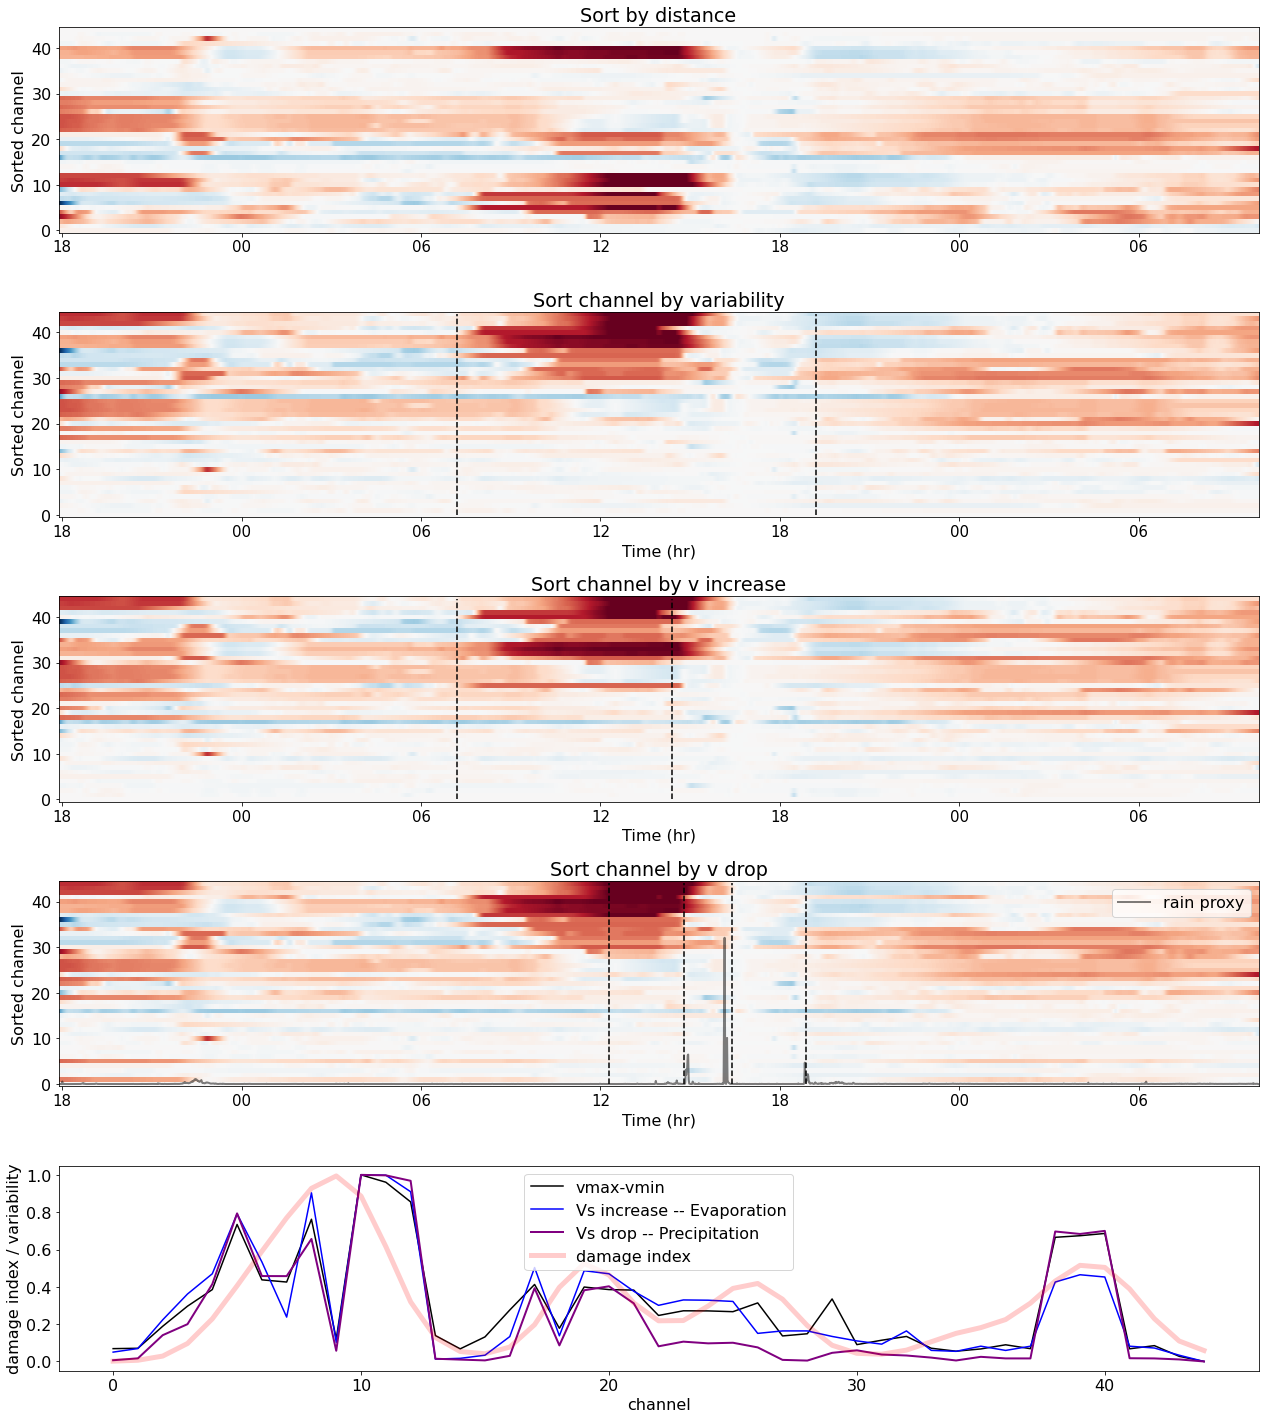

In [28]:
with h5py.File('data/final_peaks_interp_smooth.h5', 'r') as f:
    dvv_all = f['smooth1d_dvv'][:]

dvv_all = dvv_all - np.repeat(np.mean(dvv_all[:, 1345:1400], axis=1)[:, np.newaxis], 2408, axis=1)

fig, axs = plt.subplots(5, 1, figsize=(18, 20), tight_layout=True)

# Plot 1: Sort channel by mechanical damage
axs[0].pcolormesh(np.arange(2408), np.arange(45), dvv_all[6:], shading='auto', vmin=-0.4, vmax=0.4, cmap='RdBu_r')
axs[0].set_title('Sort by distance')
axs[0].set_xticks(xax)
axs[0].set_xticklabels(hrax, fontsize=15)
axs[0].set_ylabel('Sorted channel')

# Plot 2: Sort channel by variability
trim_dvv = dvv_all[6:51, 800:1520]
variability_all = np.nanmax(trim_dvv, axis=1) - np.nanmin(trim_dvv, axis=1)
axs[4].plot(variability_all/np.nanmax(variability_all), color='black', label='vmax-vmin')
variability_indices = np.argsort(variability_all) + 6

axs[1].pcolormesh(np.arange(2408), np.arange(45), dvv_all[variability_indices], shading='auto', vmin=-0.4, vmax=0.4, cmap='RdBu_r')
axs[1].set_title('Sort channel by variability')
axs[1].set_xticks(xax)
axs[1].set_xticklabels(hrax, fontsize=15)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Sorted channel')
axs[1].vlines([800, 1520], 0, 44, color='k', linestyle='--')

# Plot 3: Sort channel by v increase
trim_dvv = dvv_all[6:51, 800:1230]
variability = np.nanmax(trim_dvv, axis=1) - np.nanmin(trim_dvv, axis=1)
axs[4].plot(variability/np.nanmax(variability), color='blue', label='Vs increase -- Evaporation')
variability_indices = np.argsort(variability) + 6


axs[2].pcolormesh(np.arange(2408), np.arange(45), dvv_all[variability_indices], shading='auto', vmin=-0.4, vmax=0.4, cmap='RdBu_r')
axs[2].set_title('Sort channel by v increase')
axs[2].set_xticks(xax)
axs[2].set_xticklabels(hrax, fontsize=15)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Sorted channel')
axs[2].vlines([800, 1230], 0, 44, color='k', linestyle='--')

# Plot 4: Sort channel by v drop
trim_dvv = dvv_all[6:51, 1105:1500]
variability = np.fabs(np.nanmean(trim_dvv[:, :150], axis=1) - np.nanmean(trim_dvv[:, -150:], axis=1))
axs[4].plot(variability/np.nanmax(variability), color='purple', label='Vs drop -- Precipitation', lw=2)
variability_indices = np.argsort(variability) + 6

im=axs[3].pcolormesh(np.arange(2408), np.arange(45), dvv_all[variability_indices], shading='auto', vmin=-0.4, vmax=0.4, cmap='RdBu_r')
axs[3].set_title('Sort channel by v drop')
axs[3].set_xticks(xax)
axs[3].set_xticklabels(hrax, fontsize=15)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Sorted channel')
axs[3].vlines([1105, 1255, 1350, 1500], 0, 44, color='k', linestyle='--')
axs[3].plot(ave_psd * 50, color='k', lw=2, alpha=0.5, label='rain proxy')
axs[3].legend()

# Plot 5: all spatial variabilities and damage index
axs[4].plot(damage_index, label='damage index', color='red', lw=5, alpha=0.2)
axs[4].set_ylabel('damage index / variability')
axs[4].set_xlabel('channel')
axs[4].legend()

## Zoom in

Text(0.5, 0, 'tire pressure (bar)')

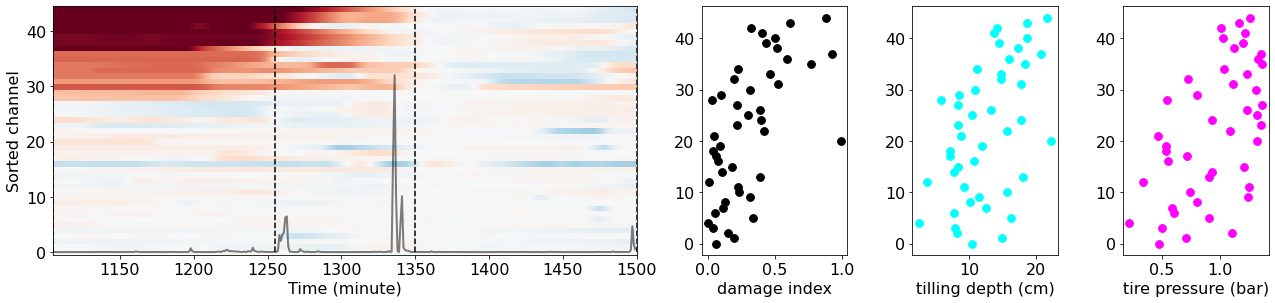

In [31]:
with h5py.File('data/final_peaks_interp_smooth.h5', 'r') as f:
    smooth1d_dvv = f['smooth1d_dvv'][:]

trim_dvv_smooth1d = smooth1d_dvv[6:51, 1105:1500]
variability1 = np.fabs(np.nanmean(trim_dvv_smooth1d[:, :150], axis=1) - np.nanmean(trim_dvv_smooth1d[:, -150:], axis=1))
variability_indices1 = np.argsort(variability1) + 6

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4.5), gridspec_kw={'width_ratios': [4, 1,1,1]}, tight_layout=True)

im = ax1.pcolor(np.arange(2408), np.arange(45), smooth1d_dvv[variability_indices1], shading='auto', vmin=-0.4, vmax=0.4, cmap='RdBu_r')

ax1.set_xlabel('Time (minute)')
ax1.set_ylabel('Sorted channel')
ax1.vlines([1105, 1255, 1350, 1500], 0, 44, color='k', linestyle='--')
ax1.plot(ave_psd * 50, color='k', lw=2, alpha=0.5, label='rain proxy')
ax1.set_xlim([1105,1500])
plt.colorbar(im, ax=axs[3])

ax2.scatter(damage_index[variability_indices1-6], np.arange(45), s=60, color='k')
ax2.set_xlabel('damage index')

ax3.scatter(tillage_interpolated[variability_indices1-6]*1.5, np.arange(45), s=60, color='cyan')
ax3.set_xlabel('tilling depth (cm)')

ax4.scatter(tire_interpolated[variability_indices1-6]*1.5/10, np.arange(45), s=60, color='magenta')
ax4.set_xlabel('tire pressure (bar)')

[Text(0, 0, '17 17:53'),
 Text(360, 0, '18 00:01'),
 Text(720, 0, '18 06:14'),
 Text(1080, 0, '18 12:17'),
 Text(1440, 0, '18 18:18'),
 Text(1800, 0, '19 00:21'),
 Text(2160, 0, '19 06:22')]

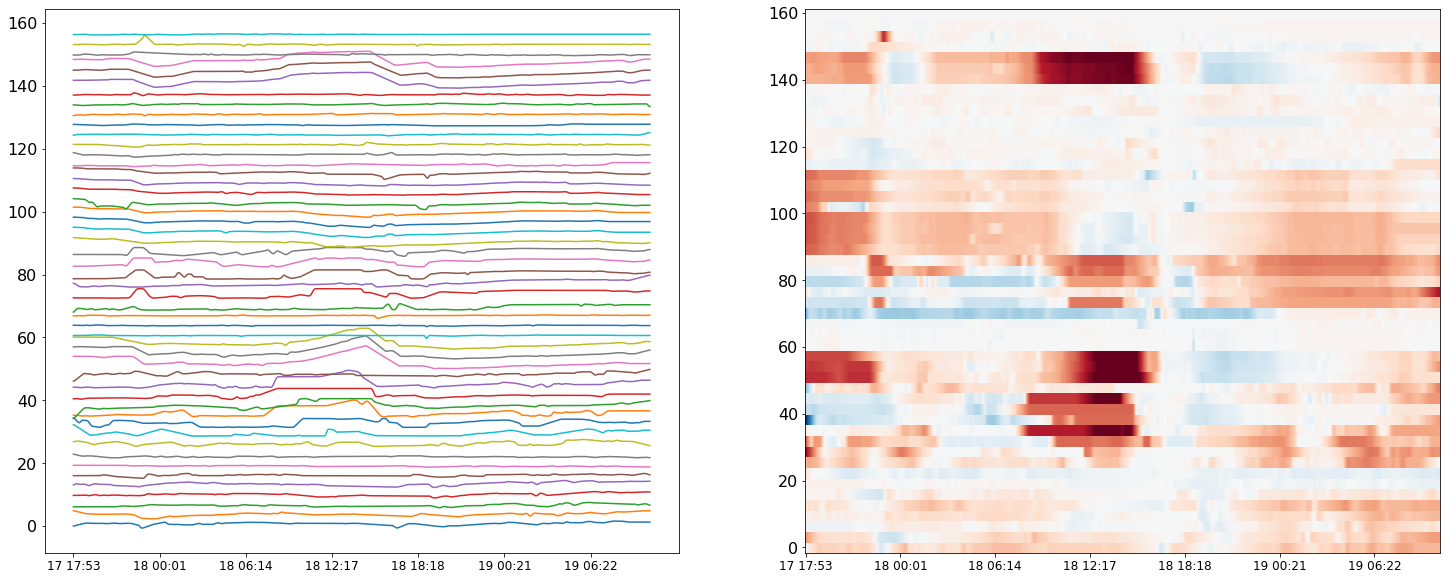

In [33]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
for i in range(50):
    ax[0].plot(np.arange(2408), 10*smooth1d_dvv[i]+i*3.19, label=f'channel {i}')

ax[1].pcolor(np.arange(2408), np.arange(51)*3.19, smooth1d_dvv, shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu_r')

xax=np.arange(0, ave_psd.shape[-1], 360)
tax=acqu_time[:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%d %H:%M') for dt in tax]

ax[0].set_xticks(xax)
ax[0].set_xticklabels(hrax, fontsize = 12)
ax[1].set_xticks(xax)
ax[1].set_xticklabels(hrax, fontsize = 12)